# Predicting Suicidal Patients during COVID-19

Author : Himani Shah and FNU Abdullah

### Data collection
### Data labelling
### Exploratory Analysis
### Naive Bayes Implementation
### Logistic Regression Implementation

In [1]:

# IMPORT PACKAGES

import praw
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import base64

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
#from scipy.misc import imread
from matplotlib import pyplot as plt
%matplotlib inline
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import log_loss
from wordcloud import WordCloud, STOPWORDS

import numpy as np
import nltk
import datetime as dt
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from collections import Counter
from nltk.tokenize import word_tokenize
import string

from pmaw import PushshiftAPI
api = PushshiftAPI()



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himanishah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load collected and labelled data

In [2]:
# Load reddit data from .csv files to dataframe
 
df1 = pd.read_csv('/Users/himanishah/Downloads/happy_watch_self.csv',header=0,index_col='Unnamed: 0')
df2 = pd.read_csv('/Users/himanishah/Downloads/suicide_watch_self.csv',header=0,index_col='Unnamed: 0')
df3 = pd.read_csv('/Users/himanishah/Documents/depression.csv',header=0)

# Data cleaning

In [3]:
# Data cleaning
df_self = df1.drop(df1[df1.selftext == '[deleted]'].index)
df_self = df1.drop(df1[df1.selftext == '[removed]'].index)

df_self

df_self['Suicidal'] = 'NS'

df_self.isnull().sum()

df_self.dropna(inplace=True)

df_self

df2_self = df2.drop(df2[df2.selftext == '[deleted]'].index)
df2_self = df2.drop(df2[df2.selftext == '[removed]'].index)

df2_self.isnull().sum()

df3_self = df3.drop(df2[df2.selftext == '[deleted]'].index)
df3_self = df3.drop(df2[df2.selftext == '[removed]'].index)


df3_self.isnull().sum()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


selftext    0
Suicidal    0
dtype: int64

In [4]:
df2_self.dropna(inplace=True)
df3_self.dropna(inplace=True)

In [5]:
df2_self.isnull().sum()
df3_self.isnull().sum()

selftext    0
Suicidal    0
dtype: int64

# Combine all three r/happy r/depression and r/suicidewatch

In [6]:

new_df_combo = df_self.append(df2_self, ignore_index=True)
new_combo = new_df_combo.append(df3,ignore_index=True)

# Shuffle the data before training

In [7]:

from sklearn.utils import shuffle
new_df_combo_shuffled = shuffle(new_combo)
new_df_combo_shuffled = new_combo.sample(frac=1).reset_index(drop=True)

In [8]:
new_df_combo_shuffled

,selftext,Suicidal
0,Closest I was to going through with it was NYE...,S
1,I'm tired of this life. I wanna die but I'm to...,S
2,After hearing about Trump’s executive orders a...,S
3,It’s gotten to the point that I either have to...,S
4,I am just beaming with joy god has granted one...,NS
...,...,...
950,"So, after being the closet my whole life. 35 y...",NS
951,I get really bad imposter syndrome. It’s somet...,NS
952,(F 23 if it matters) \nWithout going into all ...,S
953,I’ve tried to be happy but failed. I don’t wan...,S


In [9]:
new_df_combo_shuffled.columns

Index(['selftext', 'Suicidal'], dtype='object')

In [10]:
new_df_combo_shuffled

,selftext,Suicidal
0,Closest I was to going through with it was NYE...,S
1,I'm tired of this life. I wanna die but I'm to...,S
2,After hearing about Trump’s executive orders a...,S
3,It’s gotten to the point that I either have to...,S
4,I am just beaming with joy god has granted one...,NS
...,...,...
950,"So, after being the closet my whole life. 35 y...",NS
951,I get really bad imposter syndrome. It’s somet...,NS
952,(F 23 if it matters) \nWithout going into all ...,S
953,I’ve tried to be happy but failed. I don’t wan...,S


# Exploratory Data Analysis

### Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.



In [11]:
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

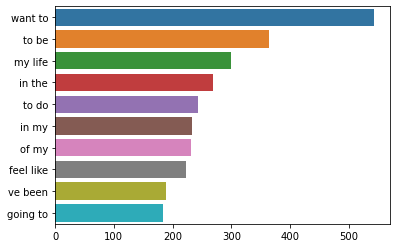

In [12]:
plot_top_ngrams_barchart(new_df_combo_shuffled['selftext'],2)

### There are lot of bigrams with similar meaning. It means that we should put some effort into data cleaning and see if we were able to combine those synonym terms into one clean token.

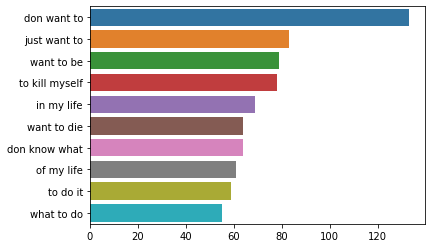

In [13]:
plot_top_ngrams_barchart(new_df_combo_shuffled['selftext'],3)

In [14]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


### Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.

* tokenize: sentences are converted to a list of words.
* remove stopwords
* lemmatize: forms of each word into a common root.
* convert to the bag of words: Bag of words is a dictionary where the keys are words and values are the number of times each word occurs in the text.


In [15]:
# Code Snippet for Creating LDA visualization

import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models


# import pyLDAvis.gensim


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

In [16]:
import nltk
nltk.download('punkt')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/himanishah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
lda_model, bow_corpus, dic = get_lda_objects(new_df_combo_shuffled['selftext'])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himanishah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7921 unique tokens: ["'ve", '2019', 'Closest', 'NYE', 'Was']...) from 955 documents (total 64205 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': 'built Dictionary(7921 unique tokens: ["\'ve", \'2019\', \'Closest\', \'NYE\', \'Was\']...) from 955 documents (total 64205 corpus positions)', 'datetime': '2021-12-13T22:31:08.151591', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.models.ldamodel:using symmetric alpha at 0.3333333333333333
INFO:gensim.models.ldamodel:using symmetric eta at 0.3333333333333333
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 3 topics, 10 passes over the supplied corpus of 955 documents, updating every 4000 documen

In [18]:
lda_model.show_topics()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[(0,
  '0.022*"n\'t" + 0.012*"life" + 0.010*"want" + 0.008*"like" + 0.008*"get" + 0.008*"know" + 0.008*"feel" + 0.006*"people" + 0.006*"would" + 0.006*"time"'),
 (1,
  '0.007*"feel" + 0.006*"want" + 0.005*"day" + 0.005*"know" + 0.005*"n\'t" + 0.005*"http" + 0.005*"time" + 0.004*"one" + 0.004*"hair" + 0.004*"fucking"'),
 (2,
  '0.015*"like" + 0.013*"n\'t" + 0.013*"want" + 0.012*"feel" + 0.009*"know" + 0.009*"life" + 0.009*"get" + 0.008*"year" + 0.008*"time" + 0.007*"even"')]

# Results of LDA in interactive way

In [19]:
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.046740 -0.032880       1        1  57.276686
0     -0.038734  0.034999       2        1  33.980259
1      0.085473 -0.002119       3        1   8.743055, topic_info=         Term        Freq       Total Category  logprob  loglift
33        n't  975.000000  975.000000  Default  30.0000  30.0000
19       feel  645.000000  645.000000  Default  29.0000  29.0000
280   fucking  248.000000  248.000000  Default  28.0000  28.0000
10        day  301.000000  301.000000  Default  27.0000  27.0000
514      http   51.000000   51.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
22        get   14.665548  520.026569   Topic3  -5.9474  -1.1315
140     would   13.264335  343.782802   Topic3  -6.0478  -0.8180
6    anything   11.834347  203.588292   Topic3  -6.1619  -0.4082
91       even   12.570462  386.388511   Topic3  -6.1016  -0.9886
0         've   12.246809  324.072166   Topic3  -6.1277  -0.8388

[283 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
290       1  0.444417    'll
290       2  0.518487    'll
290       3  0.032920    'll
0         1  0.635661    've
0         2  0.327088    've
...     ...       ...    ...
1002      2  0.081489  x200B
1002      3  0.040744  x200B
55        1  0.709821   year
55        2  0.238164   year
55        3  0.051369   year

[429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

* The area of each circle represents the importance of the topic relative to the corpus. As there are three topics, we have three circles. 
* The distance between the center of the circles indicates the similarity between the topics. * Here you can see that the topic 1 and topic 2 are relatively closer indicating that the topics are more similar.
* The histogram of each topic shows the top 30 relevant words. For example, in topic 3 the most relevant words are feel, want , day and so on..

So in our case, we can see a lot of words and topics associated with life, feeling, like and want in the corpus.

# Sentiment analysis

### Sentiment analysis is a very common natural language processing task in which we determine if the text is positive, negative or neutral. 

In [20]:
pip install textblob

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Note: you may need to restart the kernel to use updated packages.


In [21]:
from textblob import TextBlob

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [22]:
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



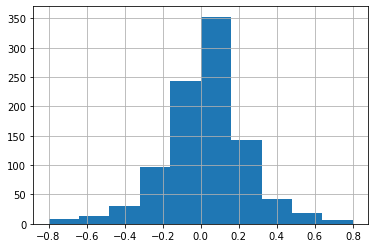

In [23]:
plot_polarity_histogram(new_df_combo_shuffled['selftext'])

### We can notice that range is majorly between -0.2 to 0.2 indicating there are mix of all kinds to sentiment (negative, positive, neutral).

# Exploring through text complexity

In [24]:
pip install textstat

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Note: you may need to restart the kernel to use updated packages.


In [25]:
# Code Snippet for Text Complexity Histogram

from textstat import flesch_reading_ease

def plot_text_complexity_histogram(text):
    text.\
        apply(lambda x : flesch_reading_ease(x)).\
        hist()
    


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



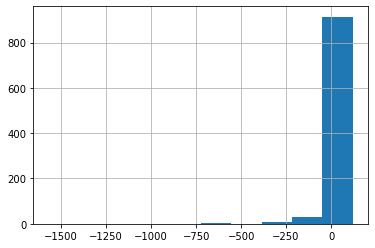

In [26]:
plot_text_complexity_histogram(new_df_combo_shuffled['selftext'])

### Almost all of the readability scores fall above 0. This means that an average person can read and understand the data.

# Split data into test and train

In [52]:
train=new_df_combo_shuffled.sample(frac=0.8,random_state=200) 
test=new_df_combo_shuffled.drop(train.index)

y = train.Suicidal.values
xtrain, xvalid, ytrain, yvalid = train_test_split(train.selftext.values.astype('U'), y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

##Shape of the dataset
print(train.shape)
print(xtrain.shape)
print(xvalid.shape)
print(ytrain.shape)
print(yvalid.shape)

(764, 2)
(687,)
(77,)
(687,)
(77,)


In [44]:
from math import sqrt,log
import math
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [45]:
pip install gensim


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Note: you may need to restart the kernel to use updated packages.


In [49]:
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Understanding the data

In [32]:
z = {'NS': 'Not Suicidal', 'S': 'Suicidal'}

data = [go.Bar(
            x = train.Suicidal.map(z).unique(),
            y = train.Suicidal.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.Suicidal.value_counts().values
                        ),
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [33]:
all_words = train['selftext'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# WordCloud to show the words associated with suicidal and non-suicidal people.

In [34]:

suicidal_person = train[train.Suicidal=='S']['selftext'].values
nonsuicidal_person = train[train.Suicidal=='NS']['selftext'].values

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



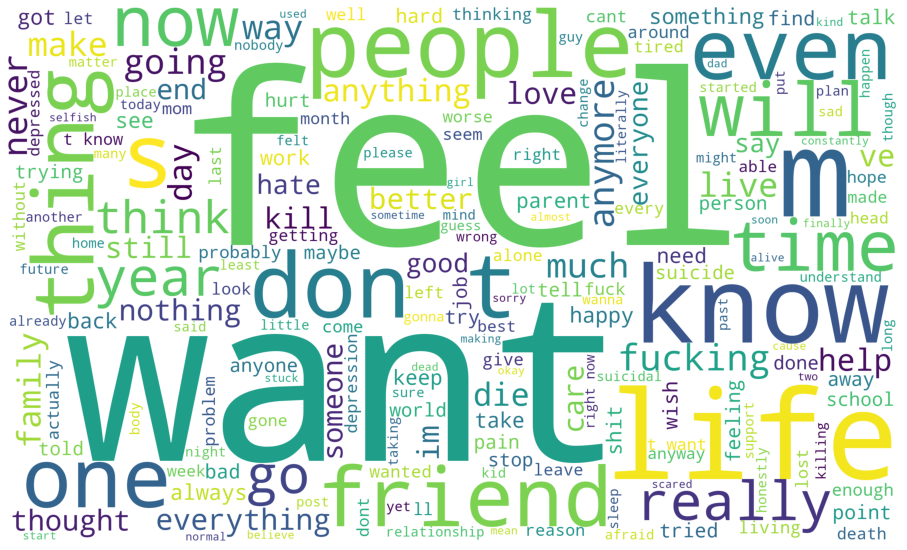

In [35]:
#WordCloud for patients
plt.figure(figsize=(16,13))
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=1500
                         ).generate(" ".join(suicidal_person))
plt.imshow(cloud)
plt.axis('off')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



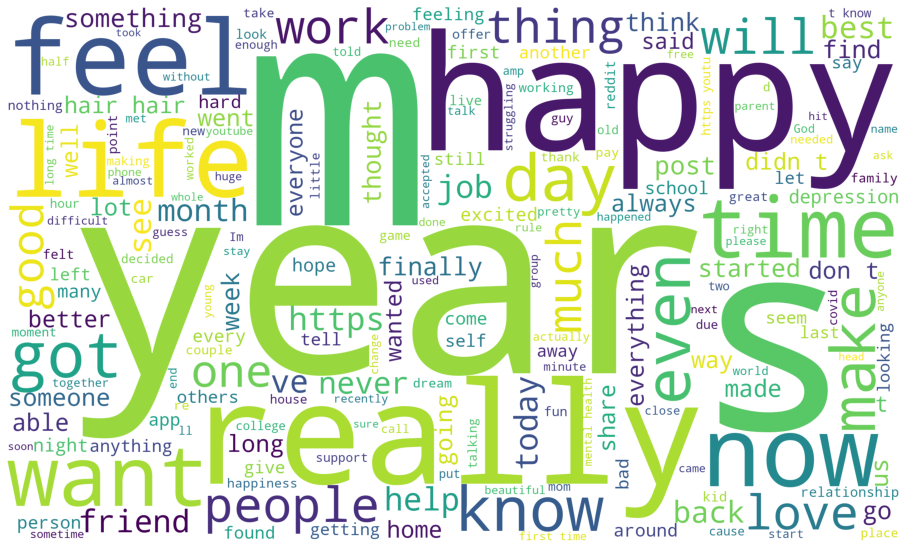

In [36]:
#WordCloud for non-patients
plt.figure(figsize=(16,13))
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=1500
                         ).generate(" ".join(nonsuicidal_person.astype(str)))
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Using the Lemmatizer to club similar words together as Lemmatizer takes into consideration the vocabulary too unlike the PorterStemmizer.

In [37]:

nltk.download('wordnet')
lemm = nltk.stem.WordNetLemmatizer()

class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


#Storing the entire training text in a list
# Calling our overwritten Count vectorizer
tfv = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')

tfv.fit(list(xtrain) + list(xvalid) + list(test))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

xtest_tfv = tfv.transform(test)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/himanishah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Naive Bayes

* We are making 3 dictionaries positive, negative and vocab. We take the words from the review, classify them into correct dictionaries on the basis of labels and calculate the frequency of each word. We calculate the denominator by laplace smoothing based on the formula above.
* We use terms which are length of positive dictionary, length of vocab dictionary and the laplace smoothing parameter.Then Calculate the priori of truthfulness and deceptiveness.
Then we find the posterior probability for the negative words and positive words by making two separate lists. We append the log inverse of the denominator that we calculate through laplace smoothing if the word is not present in the dictionary.
* If the word is already present in the dictionary either positive or negative then we divide the frequency of the word with the total frequency. This term we divide the laplace smoothing parameter that we had calculated earlier and then we take a log of this term. Then we take the sum of the positive posterior and negative posterior probabilities.

In [51]:
def NaiveBayesclassifier(xtrain, xvalid, ytrain, yvalid):
    #class the data into positive, negative and vocab dictionaries
    #claculate the frequency of each term
    
    positive={}
    negative={}
    vocab={}
    value = []
    lap = 1
    positive_posterior=[]
    negative_posterior=[]
    for words,label in zip(xtrain, ytrain):
        
        #words = re.sub(r'[^\w\s]', '', words)
        words = words.lower()
        words = remove_stopwords(words)
        punctuations = '''!()-[]{};:'"\,<>./?@1234567890#$%^&*_~'''
        for x in words:
            if x in punctuations:
                words = words.replace(x, "")
        # print(words)
        for word in words.split():
            word = lemmatizer.lemmatize(word)
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word]=1 
            if label == "NS":
                if word in positive:
                    positive[word] +=1
                else:
                    positive[word] = 1
            if label == "S":
                if word in negative:
                    negative[word] += 1
                else:
                    negative[word] = 1
    
    # find the claculate the denominator for laplace correction
    total = len(positive)+len(negative)
    p_map_deno=len(positive)+len(vocab)*lap
    n_map_deno=len(negative)+len(vocab)*lap
    
    # calculate the priori of truthfulness and deceptiveness
    positive_ml = len(positive)/(total)
    negative_ml = len(negative)/(total)

    #calculate the posterior probability for each word
    for words in xvalid:
        positive_posterior=[]
        negative_posterior=[]
        words = words.lower()
        words = remove_stopwords(words)
        punctuations = '''!()-[]{};:'"\,<>./?@1234567890#$%^&*_~'''
        for x in words:
            if x in punctuations:
                words = words.replace(x, "")
 
        
        for word in words.split():    
            word = lemmatizer.lemmatize(word)
            if word not in negative:
                negative_posterior.append(log(1/p_map_deno))
                
            else:
                negative_posterior.append(log((negative[word]/vocab[word])/n_map_deno))

            if word not in positive:
                positive_posterior.append(log(1/n_map_deno))
                
            else:
                positive_posterior.append(log((positive[word]/vocab[word])/p_map_deno))
        
        #calculate total posterior probability
        positive_posterior.append(log(positive_ml))
        negative_posterior.append(log(negative_ml))
        sum_positive = sum(positive_posterior)
        sum_negative = sum(negative_posterior)
        if sum_positive == math.inf:
            sum_positive=-2500
        if sum_negative == math.inf:
            sum_negative=-2500
        if(sum_positive - sum_negative) > 0:
            value.append("NS")
        else:
            # (math.exp(sum(positive_posterior))<(math.exp(sum(negative_posterior))))
            value.append("S")

    return value
    

results = NaiveBayesclassifier(xtrain, xvalid, ytrain, yvalid)
    # # calculate accuracy
correct_ct = sum([ (results[i] ==  yvalid[i]) for i in range(0, len(yvalid)) ])
print("Classification accuracy = %5.2f%%" % (100.0 * correct_ct / len(yvalid)))

Classification accuracy = 81.82%


# Logistic Regression

In [39]:
#Using LogisticRegression to train the dataset and predicting it on a test dataset.
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions1 = clf.predict_proba(xvalid_tfv)
predictions = clf.predict(xtest_tfv)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [40]:
#Printing the logloss and the accuracy of the model.
print ("logloss: %0.3f " % log_loss(yvalid, predictions1))
acc_log = round(clf.score(xtrain_tfv, ytrain) * 100, 2)
print("Accuracy : %0.3f " % round(acc_log,2,), "%")

logloss: 0.177 
Accuracy : 99.710  %


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

